# Lab 1b

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fix data

In [118]:
##### Generate samples #####
def data_generator(
        n: int=100,
        mA:list[float, float]=[1.0, 0.3],
        mB:list[float, float]=[0.0, -0.1],
        sigmaA: float=0.2,
        sigmaB: int=0.3,
        sampleA: float=1.0,
        sampleB: float=1.0,
        special_A_subsample: bool=False
    ):
    
    # First row of class A is handled differently
    firstrowA = np.concatenate([
        np.random.randn(n // 2) * sigmaA - mA[0],
        np.random.randn(n // 2) * sigmaA + mA[0]
    ])

    # Create the classes
    classA = np.vstack(
        tup=(firstrowA, np.random.randn(n) * sigmaA + mA[1])
    )
    classB = np.random.randn(n, 2) * sigmaB + mB
    classB = classB.transpose()

    ### Shuffle class A
    # We have 2 alternatives for subsampling class A:
    # 1. (special_A_subsample = True) Subsample class A in a special way as written in lab specification
    # 2. (special_A_subsample = False) Create random indices for subsampling data and splitting it into training and validation datasets
    if special_A_subsample:
        print("Fixing the special case subsample of class A")
        # Subsample 20% if class A where classA[0] < 0 for training (I assume training, but could be validation. Does not matter maybe?)
        indices_A_20 = np.where(classA[0] < 0)[0]
        indices_A_20_length = indices_A_20.shape[0]
        indices_A_20_sample = np.random.choice(indices_A_20, size=int(0.2 * indices_A_20_length), replace=False)
        # Snity check
        # print(indices_A_20)
        # print(indices_A_20_sample)

        # Subsample 80% if class A where classA[0] > 0 for training
        indices_A_80 = np.where(classA[0] > 0)[0]
        indices_A_80_length = indices_A_80.shape[0]
        indices_A_80_sample = np.random.choice(indices_A_80, size=int(0.8 * indices_A_80_length), replace=False)

        # Concat the indices that will be used to extract the training samples from variable classA
        # This will also be used to determine the indices that will be validation sample
        indices_A = np.concatenate((indices_A_20_sample, indices_A_80_sample), axis=0)

    else:
        indices_A = np.random.choice(n, size=int(sampleA * n), replace=False)
    
    val_indices_A = np.setdiff1d(np.arange(n), indices_A) # get indices not used in indices_A

    # Shuffle class B
    indices_B = np.random.choice(n, size=int(sampleB * n), replace=False)
    val_indices_B = np.setdiff1d(np.arange(n), indices_B) # get indices not used in indices_B
    
    # Setup training data and validation data for the 2 classes
    classA_train = classA[:, indices_A]
    classA_val = classA[:, val_indices_A]
    classB_train = classB[:, indices_B]
    classB_val = classB[:, val_indices_B]

    # Fix training data (input and target)
    input_data_train = np.concatenate((classA_train, classB_train), axis=1)
    targets_train = np.concatenate((np.ones(classA_train.shape[1]), -np.ones(classB_train.shape[1])))

    # Fix val data (input and target)
    input_data_val = np.concatenate((classA_val, classB_val), axis=1)
    targets_val = np.concatenate((np.ones(classA_val.shape[1]), -np.ones(classB_val.shape[1])))

    # Shuffle the data
    shuffle_train_idx = np.random.permutation(input_data_train.shape[1])
    shuffle_val_idx = np.random.permutation(input_data_val.shape[1])

    # Shuffle the data
    input_data_train = input_data_train[:, shuffle_train_idx]
    targets_train = targets_train[shuffle_train_idx]

    input_data_val = input_data_val[:, shuffle_val_idx]
    targets_val = targets_val[shuffle_val_idx]

    # Add bias
    input_data_train = np.vstack(tup=(input_data_train, np.ones((1, input_data_train.shape[1]))))
    input_data_val = np.vstack(tup=(input_data_val, np.ones((1, input_data_val.shape[1]))))
        

    return classA, classB, input_data_train, targets_train, input_data_val, targets_val

##### Weight generator #####
def weight_generator(X_dim_wo_bias: int, hidden_nodes: list[int], output_nodes: int=1):
    weights = []
    delta_w_prev = [] # Initialize

    # Create a list to define number of nodes in each layer, starting from input layer
    # For our 2-layer perceptron, we will have 1 input layer, 1 hidden layer and 1 output layer
    layer_nodes = [X_dim_wo_bias] + hidden_nodes + [output_nodes]

    # We start from l = 1, because we will create the weights using the dimensions of previous
    # layer (columns) and number of nodes in current layer (rows). The + 1 one the columns is to add the bias term
    for i in range(1, len(layer_nodes)):
        W = np.random.randn(layer_nodes[i], layer_nodes[i - 1] + 1)

        W_prev_init = np.zeros(shape=(layer_nodes[i], layer_nodes[i - 1] + 1))

        weights.append(W)
        delta_w_prev.append(W_prev_init)
    
    return weights, delta_w_prev

### Sanity check data generator

In [114]:
classA, classB, X, target, _, _ = data_generator(mA=[2.0, 0.3], special_A_subsample=False)
print(classA.shape)
print(classB.shape)
print(X.shape)
print(target.shape)
# print(classA)

(2, 100)
(2, 100)
(3, 200)
(200,)


In [115]:
classA, classB, X, target, _, _ = data_generator(mA=[2.0, 0.3], special_A_subsample=True)
print(classA[0])
classA_indices_sample = np.where(classA[0] < 0)[0]
print(classA_indices_sample.shape[0])
# print(np.where(classA[0] > 0))

Fixing the special case subsample of class A
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[34 17 20 15  1 14 21 49 10 25]
[-2.25994948 -1.85328556 -1.94735471 -1.91200368 -2.20897172 -1.93079125
 -2.09291835 -2.26184033 -2.0843394  -2.35491394 -2.20794923 -1.93697233
 -1.99795985 -2.04996524 -1.83593004 -2.00195679 -1.78789761 -2.21719093
 -2.39205642 -2.18689071 -2.09041974 -1.92328439 -1.84420986 -1.96617459
 -2.11115008 -1.98775585 -2.20595038 -2.1984495  -1.91094329 -1.62890384
 -2.01078426 -2.23768964 -1.93934392 -2.05544038 -2.45949012 -1.77610532
 -1.79557826 -1.92763797 -2.10267862 -1.75184552 -2.29797701 -2.41636345
 -1.84440689 -2.36552846 -2.19369298 -2.05883161 -2.20204034 -2.02926419
 -1.82247905 -1.95923263  2.22197879  2.07662549  1.67493067  2.18392242
  1.91846384  2.13949428  2.10968544  1.99866953  2.17473558  1.7137745
  2.07521256  1.92401486  1.79206119  1.

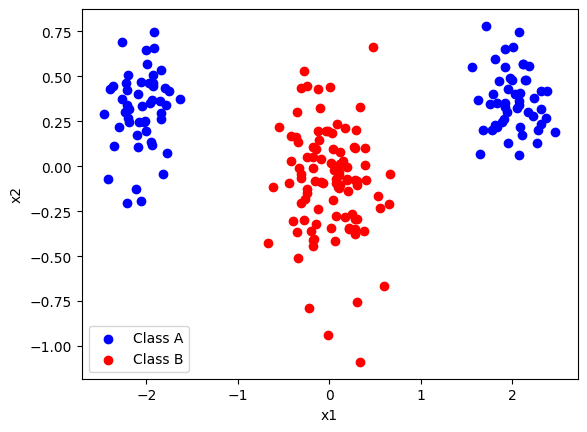

In [116]:
plt.scatter(classA[0, :], classA[1, :], color="blue", label="Class A")
plt.scatter(classB[0, :], classB[1, :], color="red", label="Class B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## Helper functions

In [65]:
def mse(targets, predicted):
       e = targets - predicted
       return 0.5 * np.mean(e**2)

def accuracy(targets, predicted):
    pred = np.where(predicted>0, 1, 0)
    true = np.where(targets>0, 1, 0)
    acc = np.count_nonzero(pred == true) / targets.size
    return acc

def plot_learning_curve(epochs, train_mse, train_ratios, val_mse=None, val_ratios=None):
    
    plt.plot(epochs, train_mse, color="red", label="MSE (Train)")
    plt.plot(epochs, train_ratios, color="blue", label="Correct class ratio (Train)")

    if val_mse:
        print("Here")
        plt.plot(epochs, val_mse, color="red", label="MSE (Val)", linestyle='--')
        plt.plot(epochs, val_ratios, color="blue", label="Correct class ratio (Val)", linestyle='--')
        
    plt.title('MSE and correct classification ratio every 10 epochs')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.grid(visible=True)
    plt.legend()
    plt.show()


## Generalized delta rule

In [66]:
###### Activation function (as in the lab instructions) #####
def activation_function(h_in):
    phi = (2 / (1 + np.exp(-h_in))) - 1 #activation function
    d_phi = ((1 + phi) * (1 - phi)) / 2 #derrivative of activation function

    return phi, d_phi

##### Forward pass #####
def forward_pass(X, weights):
    #print("===== Forward pass =====")
    # List to keep track of what should be sent into the following hidden layer
    activations_list = [X] # First element is the input, and the last element correspond to the output (i.e. t)
    
    phi_and_d_phi = [] # Store results of the activation function (both the values and the derivate) 

    for i, W in enumerate(weights):
        #print(f"Layer {i}: W shape {W.shape}, input shape {activations_list[-1].shape}")
        h_in = W @ activations_list[-1] # Get the output from the latest calculated layer, and use it as input for next layer

        # Calcualte output of hidden layer and store both outpout and derivate (they will be used in back propogation)
        h_out, d_phi = activation_function(h_in)
        #print(f"Layer {i}: h_out shape {h_out.shape}, d_phi shape {d_phi.shape}")


        phi_and_d_phi.append((h_out, d_phi))

        # Calculate bias term and add it to phi (output of the layer), for all layers, except the last one
        if i < (len(weights) - 1):
            bias_term = h_out.shape[1]
            h_out = np.vstack(tup=(h_out, np.ones((1, bias_term))))

        activations_list.append(h_out)

    return activations_list, phi_and_d_phi

##### Backward pass #####
def backward_pass(targets, phi_and_d_phi, weights):
    #print("===== Backward pass =====")
    # Initialize list with the deltas. Makes it easier to call the correct delta when calculating hidden layers delta
    deltas = [None] * len(phi_and_d_phi)

    # Go through each element of phi_and_d_phi in reversed order. 
    # In the first iteration, i = len(phi_and_d_phi) - 1 (last element of phi_and_d_phi)
    for i, (h_out, d_phi) in reversed(list(enumerate(phi_and_d_phi))):
        # We handle output layer (last element of phi_and_d_phi) differently from hidden layers
        if i == len(phi_and_d_phi) - 1:
            d = (h_out - targets) * d_phi
            #print(f"Layer {i} (output): delta shape {d.shape}")
        else:
            v = weights[i + 1][:, :-1] # Drop the weighs for the bias, as the error is calculated based the weighs connecting inputs with nodes in hidden layer, or weighs connecting hiodden layer to outer layer
            #print(f"Layer {i} (hidden): v shape {v.shape}, v_transpose shape {np.transpose(v).shape}, previously calculated delta shape {deltas[i + 1].shape}, d_phi shape {d_phi.shape}")
            d = (np.transpose(v) @ deltas[i + 1]) * d_phi # Here we matrix multiply with the latest calculated delta
            #print(f"Layer {i} (hidden): delta shape {d.shape}")

        deltas[i] = d # Update the None value to the actual delta values, so the last element in deltas = delta for the output layer nodes

    return deltas

##### Weight update #####
def weight_update(alpha, eta, activations, deltas, old_weights, delta_w_prev):
    #print("===== Weight update =====")
    new_weights = [] # New updated weights
    new_delta_w = [] # Output the calculated delta_w which will be outputted and used as delta_w_prev in next epoch

    # Going from left to right in the network to update the weights. Only 2 times in our case (X and H, not the output)
    for i, old_W in enumerate(old_weights):
        #print("Update weights in layer: " + str(i))

        delta_w = (delta_w_prev[i] * alpha) - (deltas[i]@np.transpose(activations[i]) * (1 - alpha))
        W = old_W + eta * delta_w

        new_delta_w.append(delta_w)
        new_weights.append(W)

    return new_weights, new_delta_w
#Question here is: Do we use the activations we used before, or do we cacluate them new, based on the updated weights
# Answer; the activations should not be calculated again. In the next epoch we run the model with the new weights and the original input.
# These are inputted into the hidden layer, which outputs phi and the derivate of phi. This will be populated in the activation list in the forward pass
# as well as the output from the output layer. So basically;
# X (input) - never changes
# phi(WX) - recalculated in the forward pass each epoch
# output - recalculated in the forward pass each epoch
# So the list activations will be overwritten each epoch

##### Generalized Delta Rule #####
def generalised_delta_rule(
        train_X,
        train_targets,
        val_X=None,
        val_targets=None,
        epoch:int = 100,
        eta:float = 0.01,
        alpha: float=0.9,
        hidden_nodes: int=5
    ):
    # Initialize weights
    weights, delta_w_prev = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[hidden_nodes], output_nodes=1)

    epoch_list = []
    train_mse_list = []
    train_ratio_list = []
    val_mse_list = []
    val_ratio_list = []

    for i in range(epoch):
        activation_list, phi_and_d_phi = forward_pass(X=train_X, weights=weights)
        if val_X is not None:
            val_activation_list, _ = forward_pass(X=val_X, weights=weights)

        deltas = backward_pass(targets=train_targets, phi_and_d_phi=phi_and_d_phi, weights=weights)
        weights, delta_w_prev = weight_update(alpha=alpha, eta=eta, deltas=deltas, activations=activation_list, old_weights=weights, delta_w_prev=delta_w_prev)

        # Print training accuracy every 10 epochs
        if i%10 == 0:
            train_predicted = activation_list[-1].ravel() # Make the arry 1 dimensional
            # Calculate the MSE and the accuracy ratio
            train_mse = mse(targets=train_targets, predicted=train_predicted)
            train_correct_class_ratio = accuracy(targets=train_targets, predicted=train_predicted)
            # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
            epoch_list.append(i)
            train_mse_list.append(train_mse)
            train_ratio_list.append(train_correct_class_ratio)
            
            if val_X is not None:
                val_predicted = val_activation_list[-1].ravel() # Make the arry 1 dimensional
                # Calculate the MSE and the accuracy ratio
                val_mse = mse(targets=val_targets, predicted=val_predicted)
                val_correct_class_ratio = accuracy(targets=val_targets, predicted=val_predicted)
                # print(f"Epoch {i} - MSE: {mean_squared_error}, missclassification ratio: {correct_class_ratio}")
                
                val_mse_list.append(val_mse)
                val_ratio_list.append(val_correct_class_ratio)
                
            
            
    
    print(f"Hidden nodes: {hidden_nodes}, eta: {eta}, alpha: {alpha}")
    plot_learning_curve(
        epochs=epoch_list,
        train_mse=train_mse_list,
        train_ratios=train_ratio_list,
        val_mse=val_mse_list,
        val_ratios=val_ratio_list
    )


## Testing

In [7]:
classA, classB, X, targets = data_generator(mA=[2.0, 0.3])
# Create weights for 2 perceptron layer (1 hidden layer and 1 output layer)
weights, delta_w_prev = weight_generator(X_dim_wo_bias=X.shape[0] - 1, hidden_nodes=[5], output_nodes=1)

# Forward pass
activation_list, phi_and_d_phi = forward_pass(X=X, weights=weights)

# Backward pass
deltas = backward_pass(targets=targets, phi_and_d_phi=phi_and_d_phi, weights=weights)

# Update weights
weights_updated, delta_w_prev = weight_update(alpha=0.9, eta = 0.01, deltas=deltas, activations=activation_list, old_weights=weights, delta_w_prev=delta_w_prev)

print(deltas[0].shape)
print(activation_list[0].shape)
print(weights[0].shape)
print("Sanity check that weights are updated")
print(f"First weights: {weights}")
print(f"Updated weights: {weights_updated}")

print(targets.shape)
print(targets)
print(activation_list[-1].ravel().shape)

print(targets - activation_list[-1].ravel())

print(type(targets))
print(type(activation_list[-1]))

(5, 200)
(3, 200)
(5, 3)
Sanity check that weights are updated
First weights: [array([[ 0.04797506, -0.87167415, -0.11611457],
       [-0.39726019,  0.89635847, -0.85369575],
       [ 0.11735687, -2.04558094,  0.08512327],
       [-0.47150375, -2.48947106,  0.07596129],
       [-1.09733144, -0.19635433,  1.23536717]]), array([[ 0.7097247 ,  0.47850116, -0.23611135, -0.69736105,  0.28303509,
         0.7227102 ]])]
Updated weights: [array([[ 0.04907043, -0.86691644, -0.12704412],
       [-0.39890605,  0.89880112, -0.85945321],
       [ 0.11683873, -2.04690879,  0.08845911],
       [-0.4687914 , -2.4928817 ,  0.08652441],
       [-1.09514762, -0.19529868,  1.23153243]]), array([[ 0.7055731 ,  0.49642991, -0.25043971, -0.71340904,  0.25753772,
         0.69223361]])]
(200,)
[-1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.
  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.
  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.

In [8]:
for i in activation_list:
    print(i.shape)

(3, 200)
(6, 200)
(1, 200)


In [9]:
for i in weights:
    print(i.shape)

(5, 3)
(1, 6)


In [10]:
a = np.ones(shape=(2, 2))
b = np.random.randn(2, 2)
print(a)
print(b)
print(a*b)

[[1. 1.]
 [1. 1.]]
[[-0.46168274 -0.37436615]
 [ 1.58633215 -0.01023882]]
[[-0.46168274 -0.37436615]
 [ 1.58633215 -0.01023882]]


 ## Testing the backprop

Hidden nodes: 5, eta: 0.01, alpha: 0.9


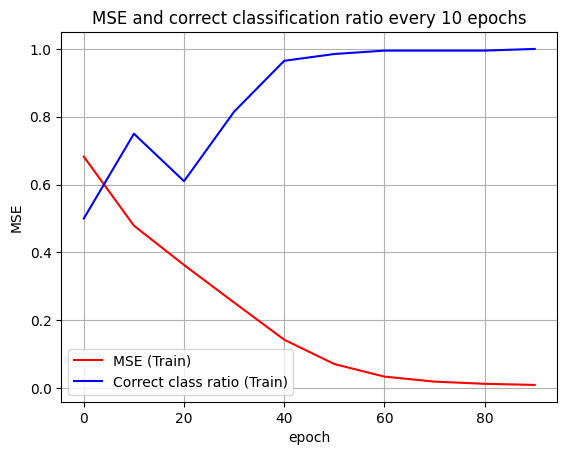

In [69]:
classA, classB, X, targets, _, _ = data_generator(mA=[2.0, 0.3])
generalised_delta_rule(X, targets, eta=0.01)

## Assignment - Part 1

In [71]:
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3])

Hidden nodes: 1, eta: 0.01, alpha: 0.9


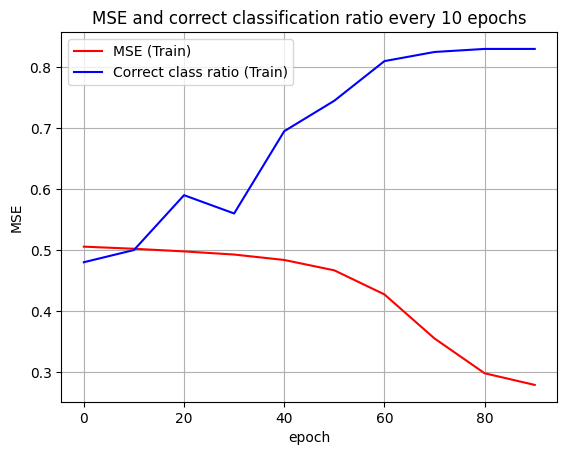

Hidden nodes: 2, eta: 0.01, alpha: 0.9


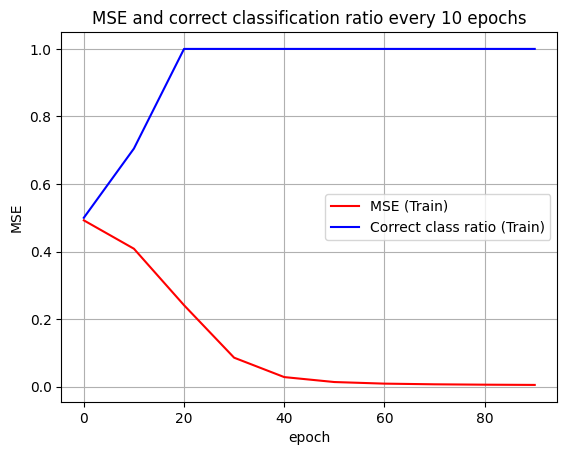

Hidden nodes: 3, eta: 0.01, alpha: 0.9


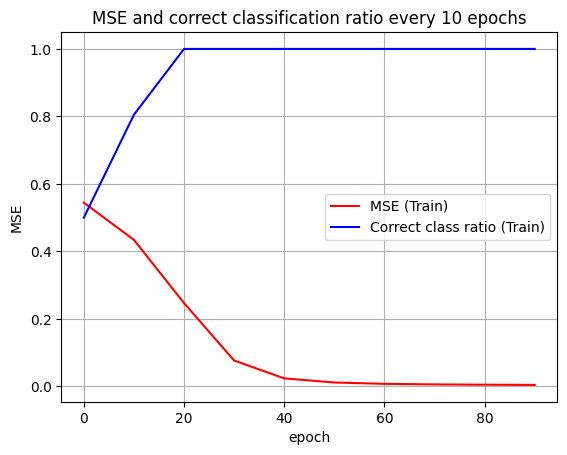

Hidden nodes: 4, eta: 0.01, alpha: 0.9


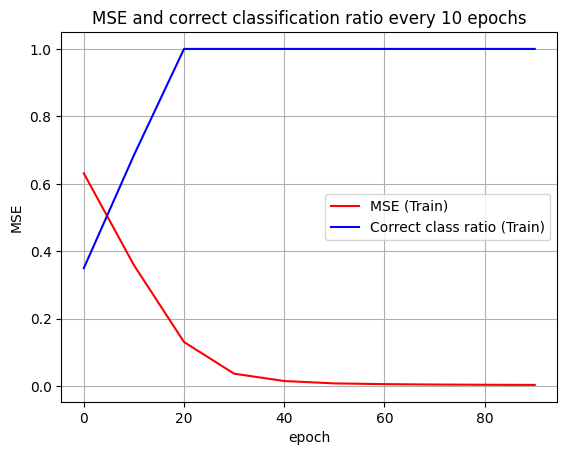

Hidden nodes: 5, eta: 0.01, alpha: 0.9


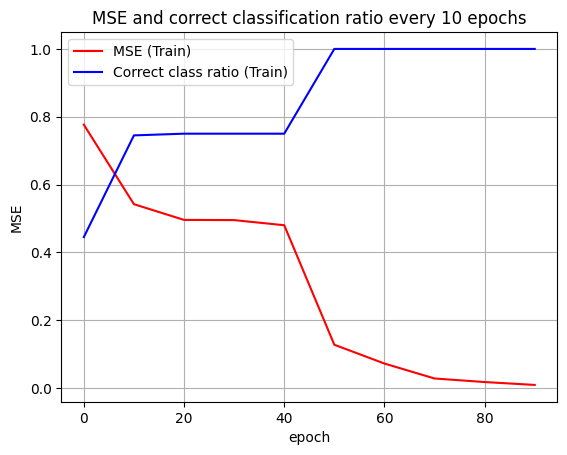

Hidden nodes: 6, eta: 0.01, alpha: 0.9


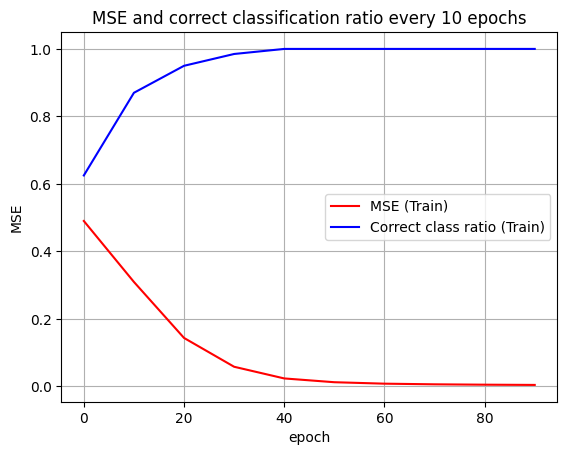

Hidden nodes: 7, eta: 0.01, alpha: 0.9


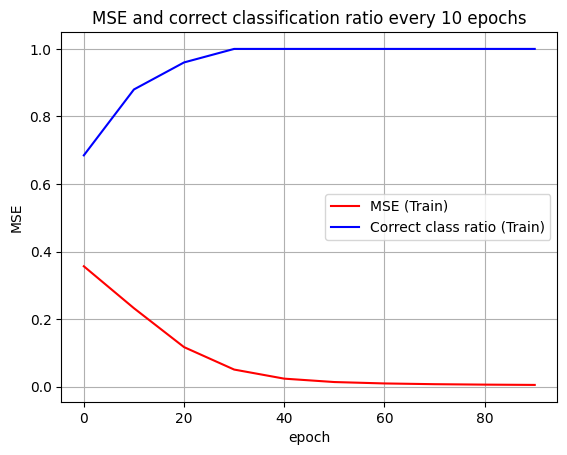

Hidden nodes: 8, eta: 0.01, alpha: 0.9


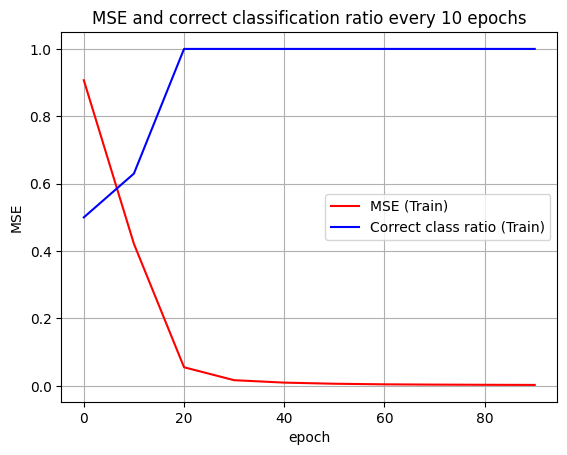

Hidden nodes: 9, eta: 0.01, alpha: 0.9


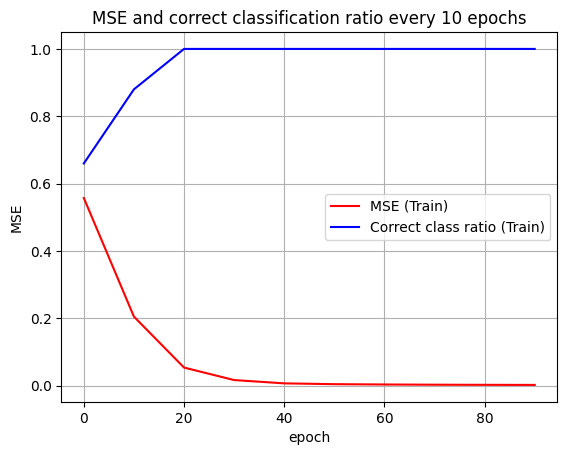

Hidden nodes: 10, eta: 0.01, alpha: 0.9


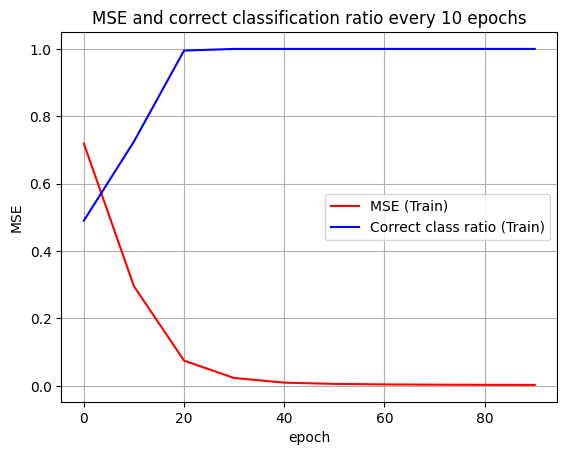

Hidden nodes: 11, eta: 0.01, alpha: 0.9


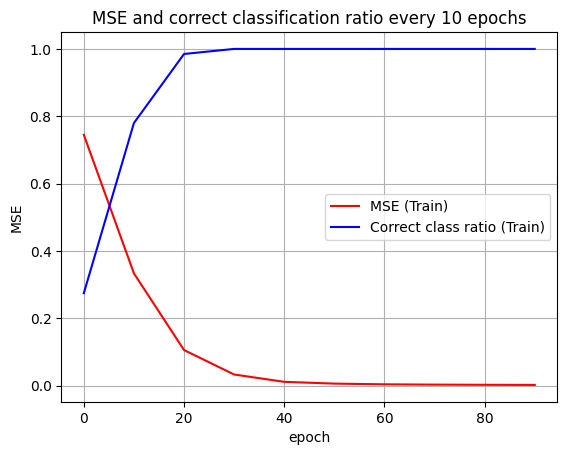

Hidden nodes: 12, eta: 0.01, alpha: 0.9


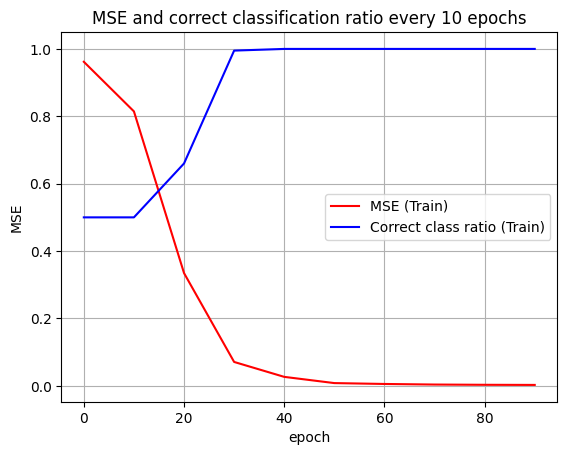

Hidden nodes: 13, eta: 0.01, alpha: 0.9


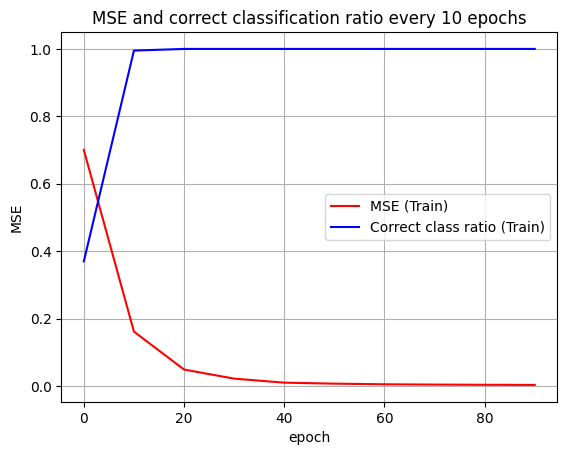

Hidden nodes: 14, eta: 0.01, alpha: 0.9


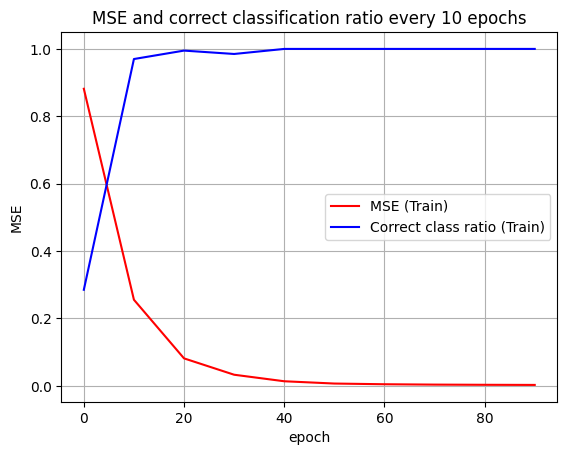

In [72]:
# Question 1 - Modify number of hidden nodes and demonstrate effect of the size of the hidden layer on performance
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Hidden nodes: 1, eta: 0.01, alpha: 0.9
Here


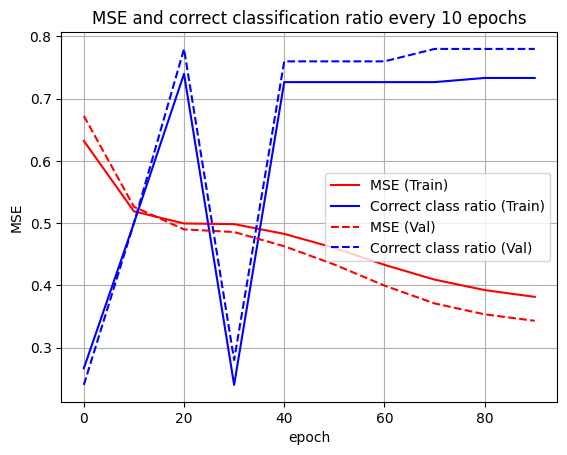

Hidden nodes: 2, eta: 0.01, alpha: 0.9
Here


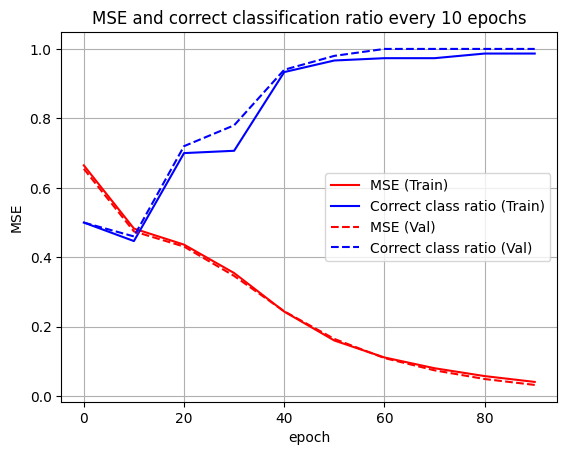

Hidden nodes: 3, eta: 0.01, alpha: 0.9
Here


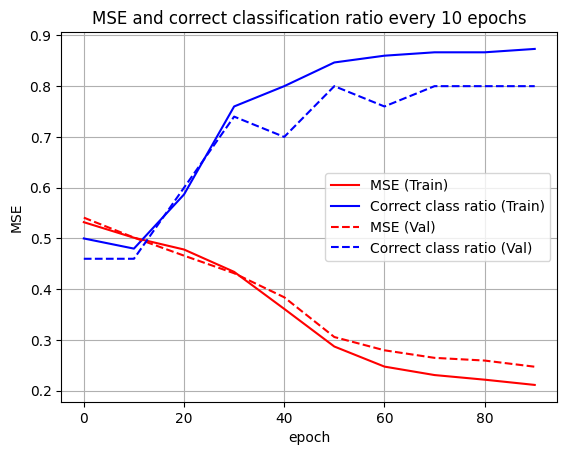

Hidden nodes: 4, eta: 0.01, alpha: 0.9
Here


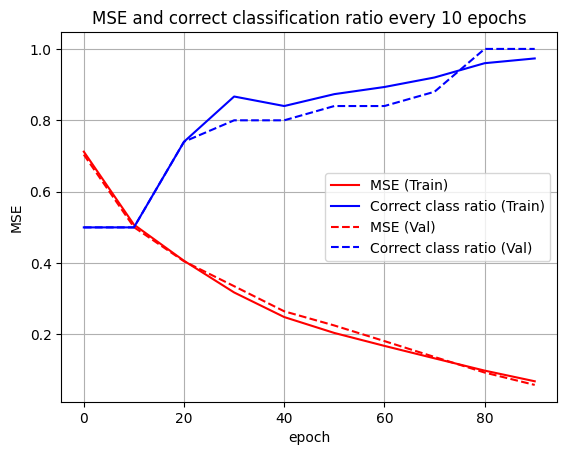

Hidden nodes: 5, eta: 0.01, alpha: 0.9
Here


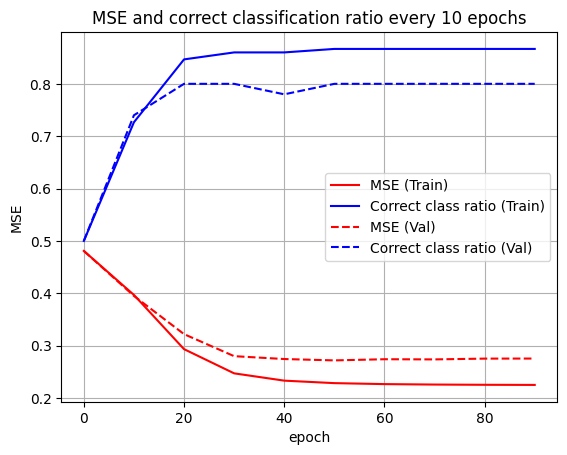

Hidden nodes: 6, eta: 0.01, alpha: 0.9
Here


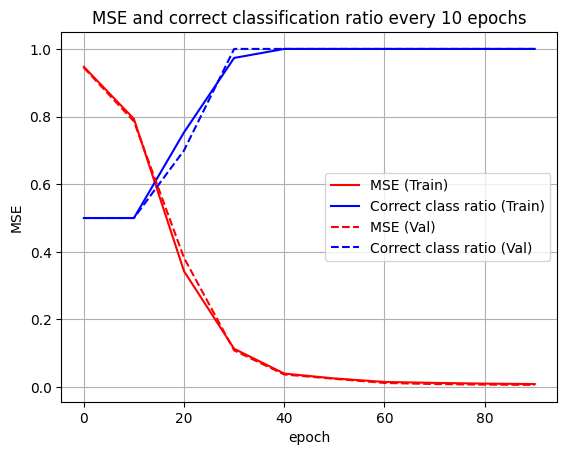

Hidden nodes: 7, eta: 0.01, alpha: 0.9
Here


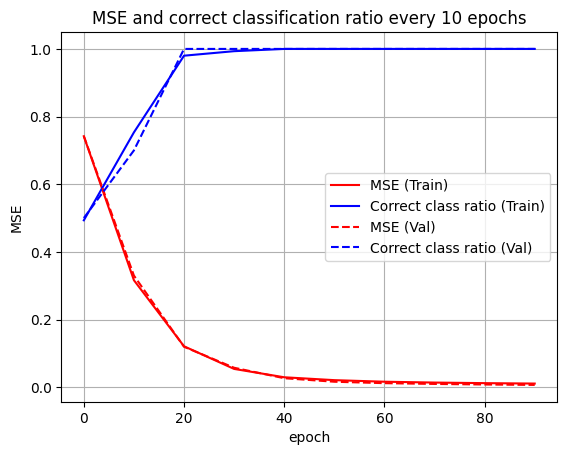

Hidden nodes: 8, eta: 0.01, alpha: 0.9
Here


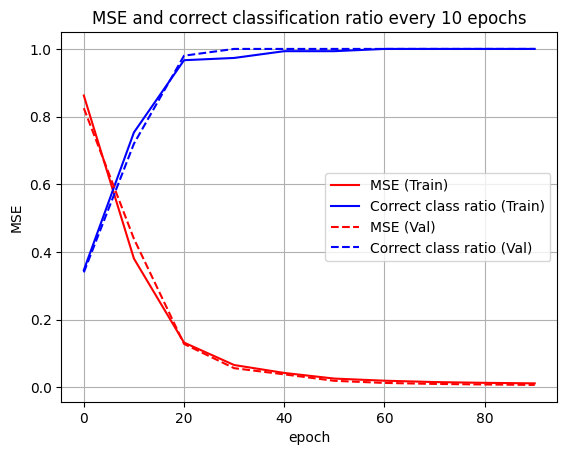

Hidden nodes: 9, eta: 0.01, alpha: 0.9
Here


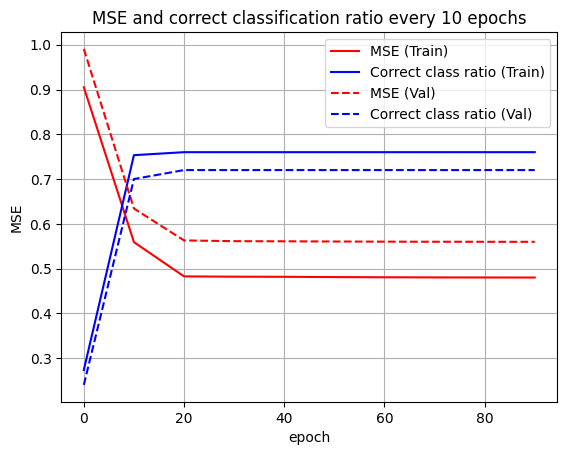

Hidden nodes: 10, eta: 0.01, alpha: 0.9
Here


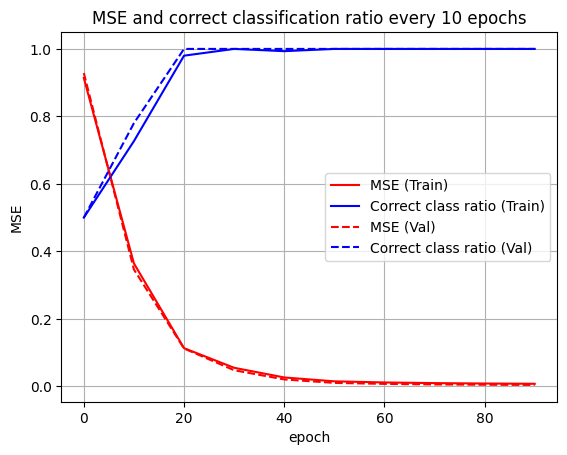

Hidden nodes: 11, eta: 0.01, alpha: 0.9
Here


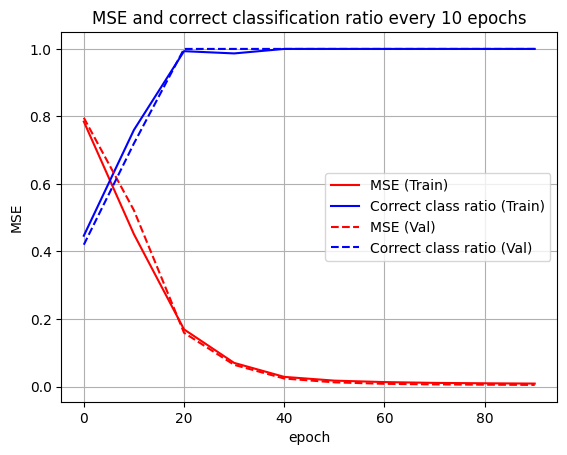

Hidden nodes: 12, eta: 0.01, alpha: 0.9
Here


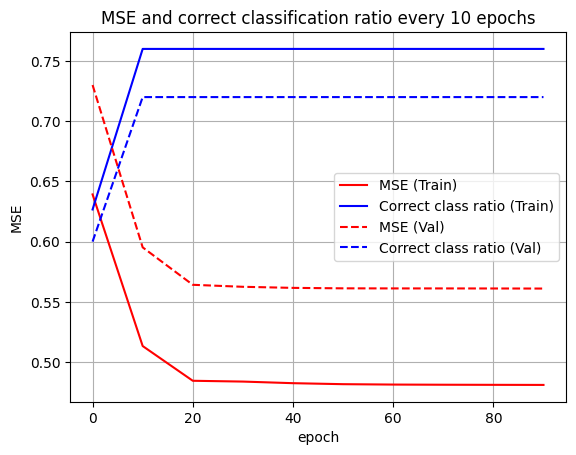

Hidden nodes: 13, eta: 0.01, alpha: 0.9
Here


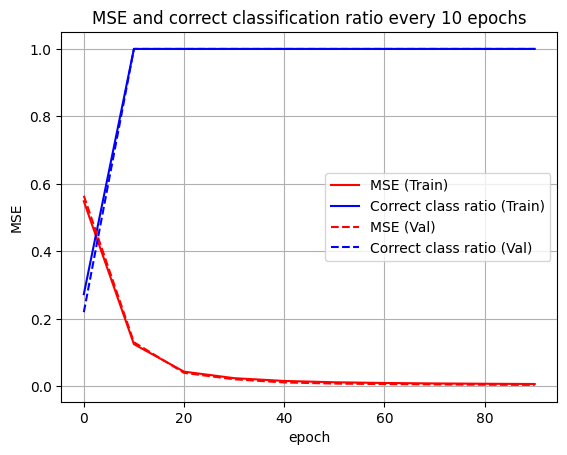

Hidden nodes: 14, eta: 0.01, alpha: 0.9
Here


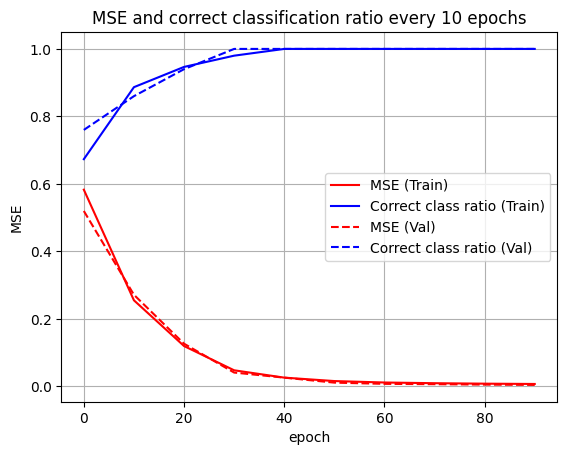

In [75]:
## Question 2 - Work with val data (75% training data and 25% validation data for each class)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=0.75, sampleB=0.75, special_A_subsample=False)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Hidden nodes: 1, eta: 0.01, alpha: 0.9
Here


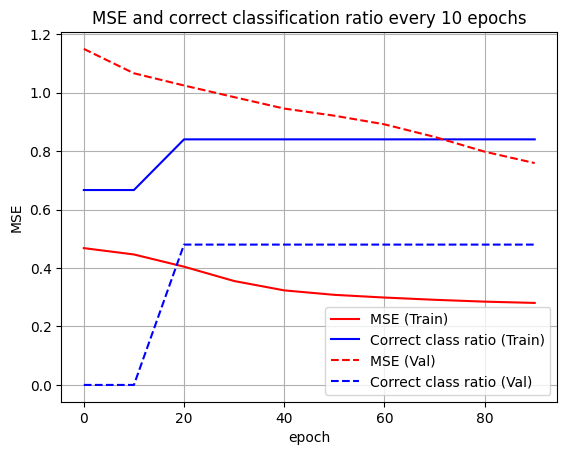

Hidden nodes: 2, eta: 0.01, alpha: 0.9
Here


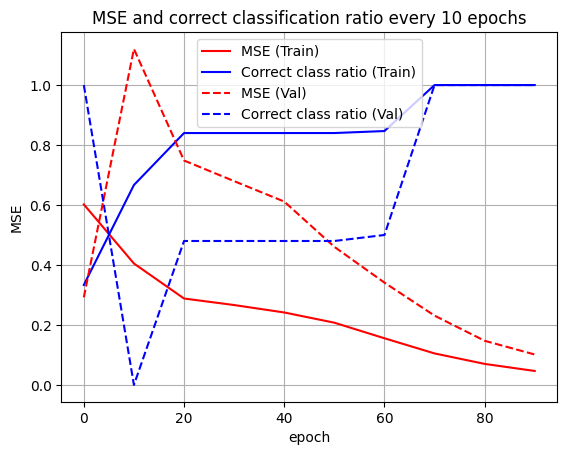

Hidden nodes: 3, eta: 0.01, alpha: 0.9
Here


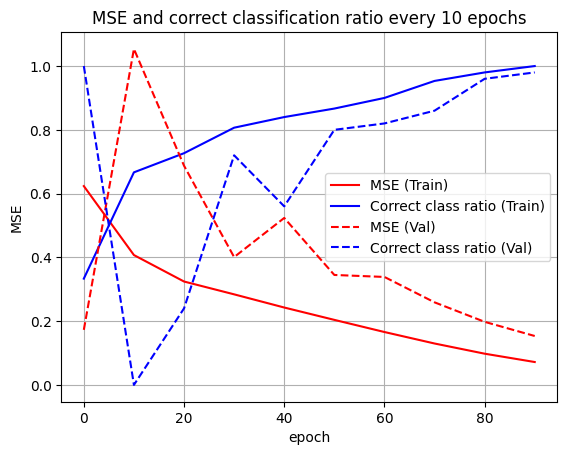

Hidden nodes: 4, eta: 0.01, alpha: 0.9
Here


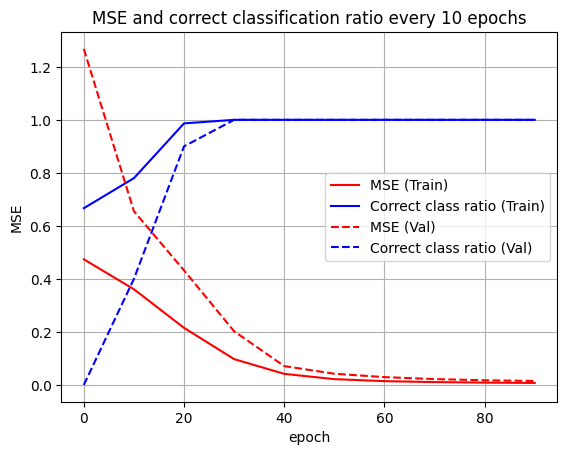

Hidden nodes: 5, eta: 0.01, alpha: 0.9
Here


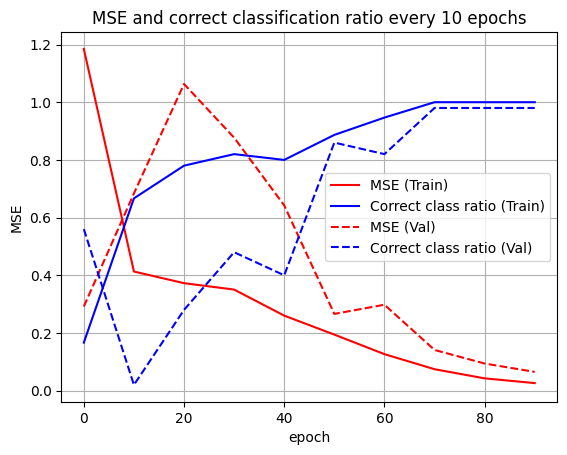

Hidden nodes: 6, eta: 0.01, alpha: 0.9
Here


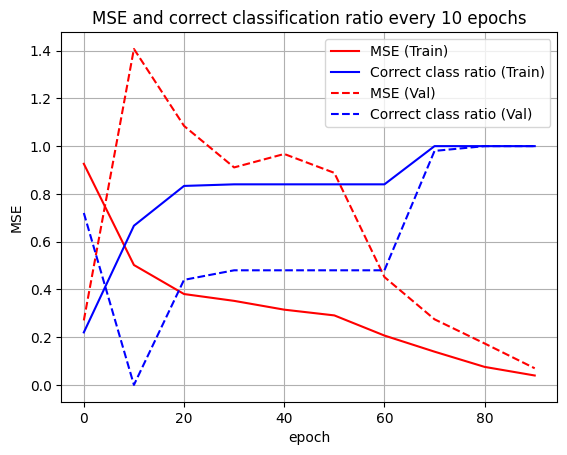

Hidden nodes: 7, eta: 0.01, alpha: 0.9
Here


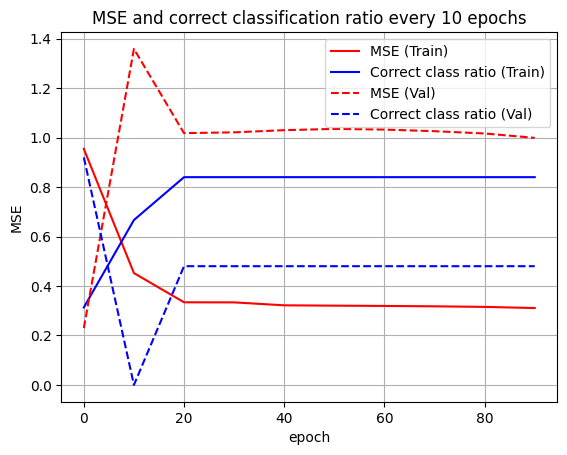

Hidden nodes: 8, eta: 0.01, alpha: 0.9
Here


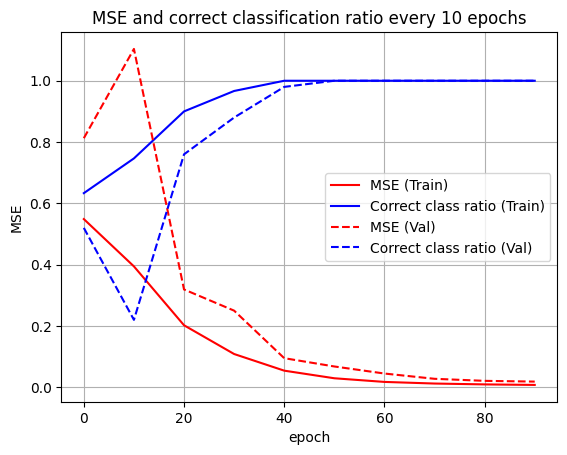

Hidden nodes: 9, eta: 0.01, alpha: 0.9
Here


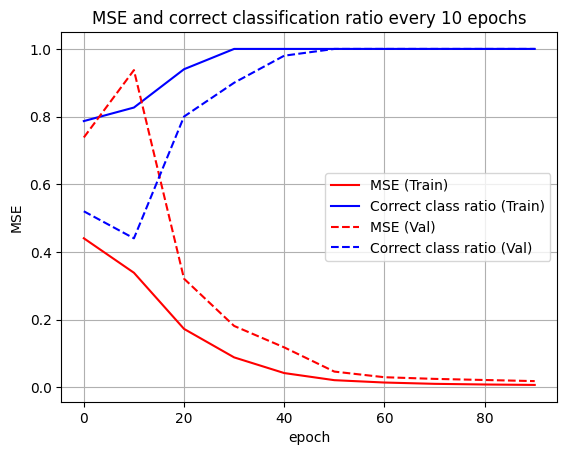

Hidden nodes: 10, eta: 0.01, alpha: 0.9
Here


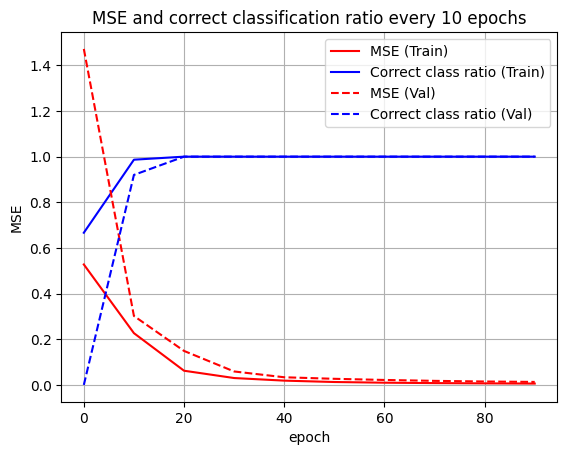

Hidden nodes: 11, eta: 0.01, alpha: 0.9
Here


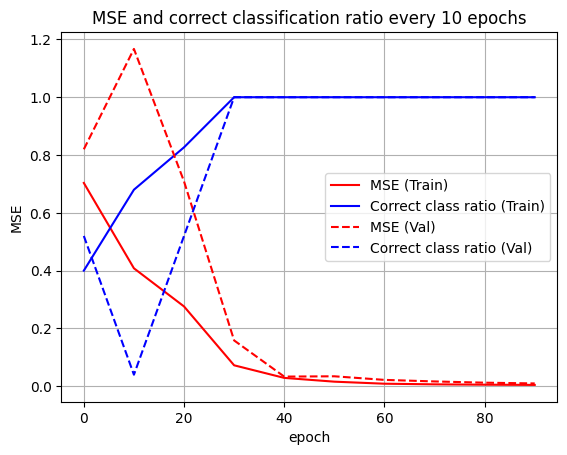

Hidden nodes: 12, eta: 0.01, alpha: 0.9
Here


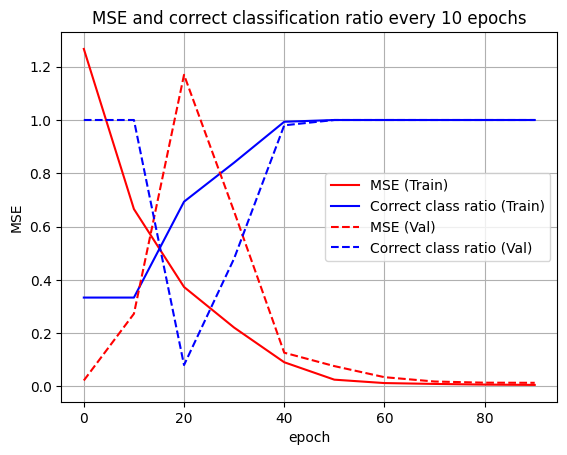

Hidden nodes: 13, eta: 0.01, alpha: 0.9
Here


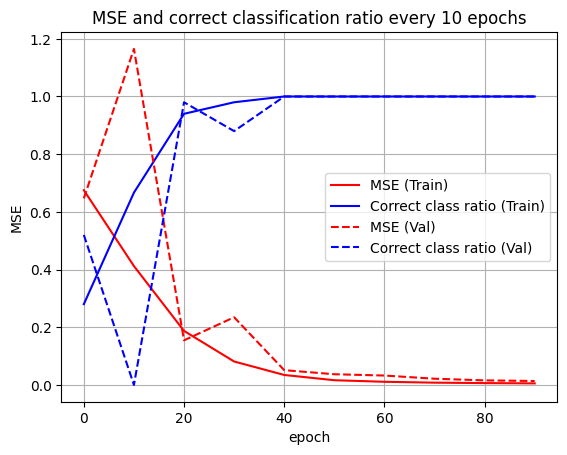

Hidden nodes: 14, eta: 0.01, alpha: 0.9
Here


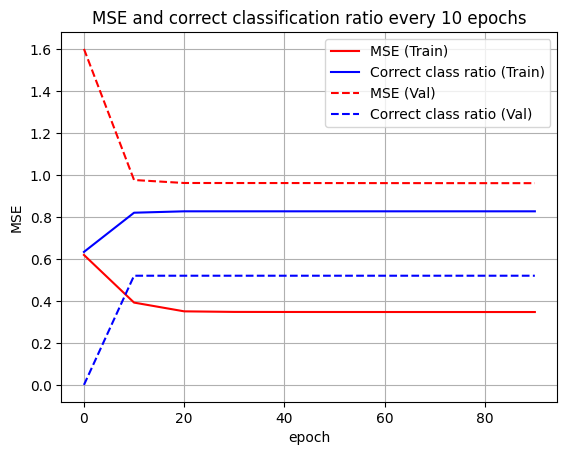

In [76]:
## Question 2 - Work with val data (50% training data and 50% validation data for class A only)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=0.50, sampleB=1.0, special_A_subsample=False)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)

Fixing the special case subsample of class A
Hidden nodes: 1, eta: 0.01, alpha: 0.9
Here


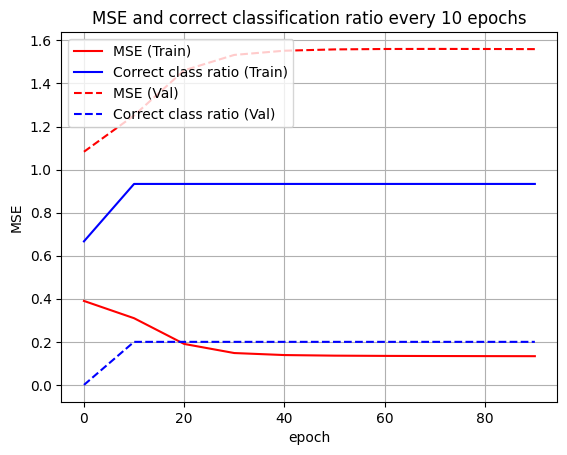

Hidden nodes: 2, eta: 0.01, alpha: 0.9
Here


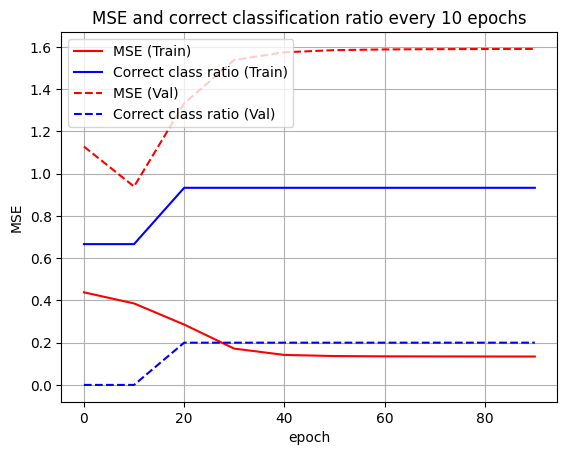

Hidden nodes: 3, eta: 0.01, alpha: 0.9
Here


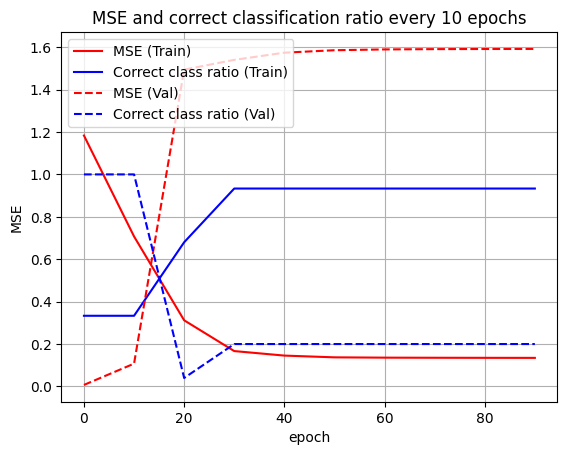

Hidden nodes: 4, eta: 0.01, alpha: 0.9
Here


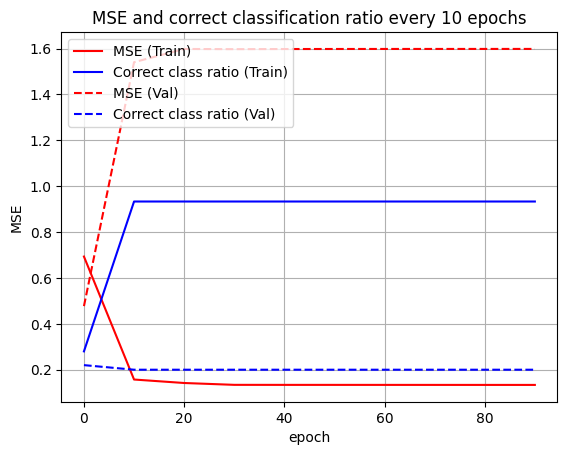

Hidden nodes: 5, eta: 0.01, alpha: 0.9
Here


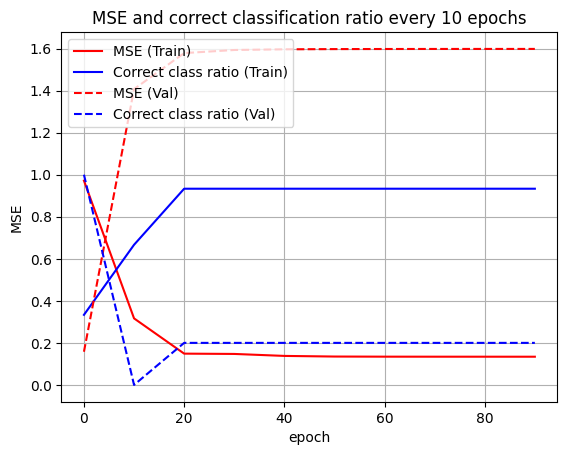

Hidden nodes: 6, eta: 0.01, alpha: 0.9
Here


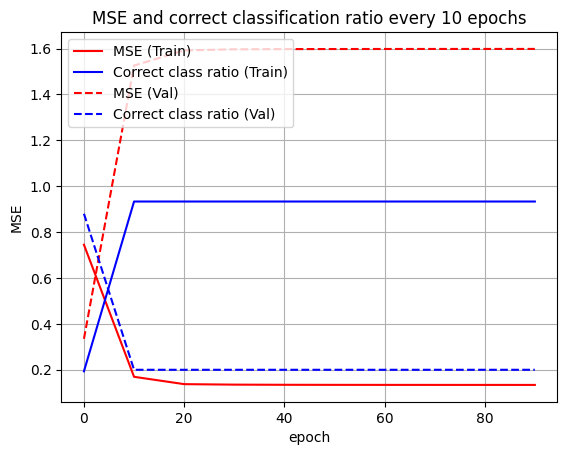

Hidden nodes: 7, eta: 0.01, alpha: 0.9
Here


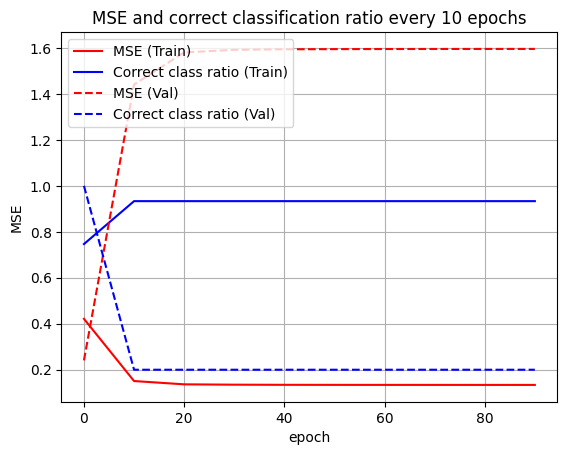

Hidden nodes: 8, eta: 0.01, alpha: 0.9
Here


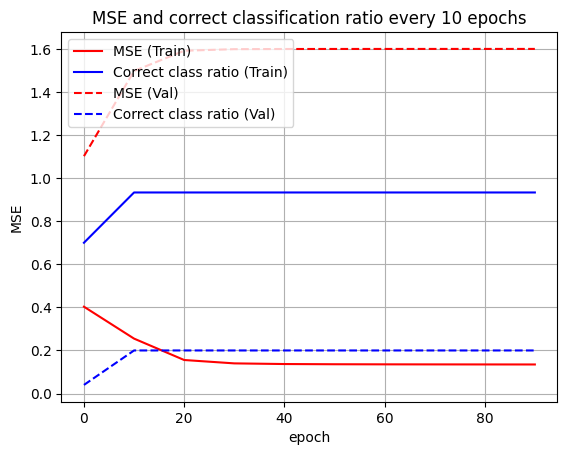

Hidden nodes: 9, eta: 0.01, alpha: 0.9
Here


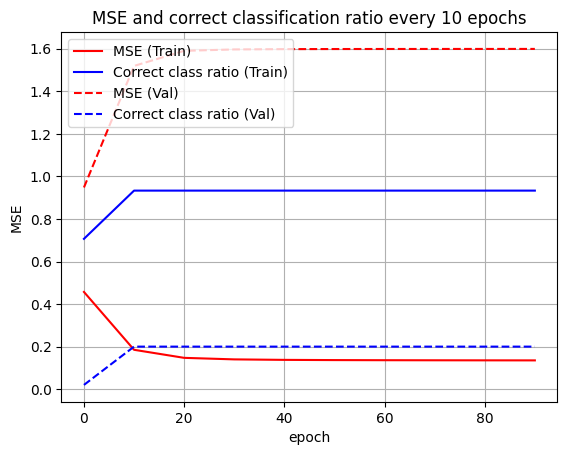

Hidden nodes: 10, eta: 0.01, alpha: 0.9
Here


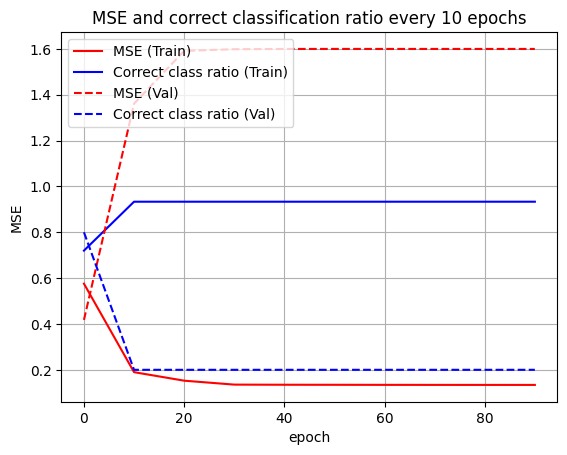

Hidden nodes: 11, eta: 0.01, alpha: 0.9
Here


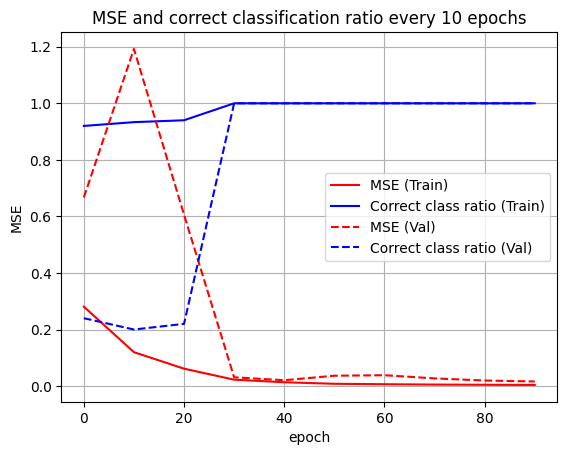

Hidden nodes: 12, eta: 0.01, alpha: 0.9
Here


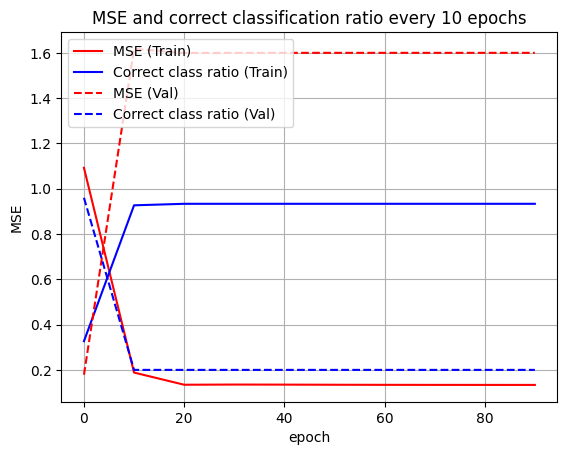

Hidden nodes: 13, eta: 0.01, alpha: 0.9
Here


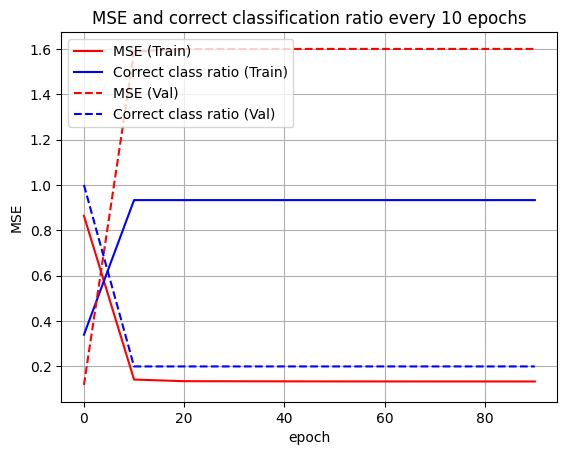

Hidden nodes: 14, eta: 0.01, alpha: 0.9
Here


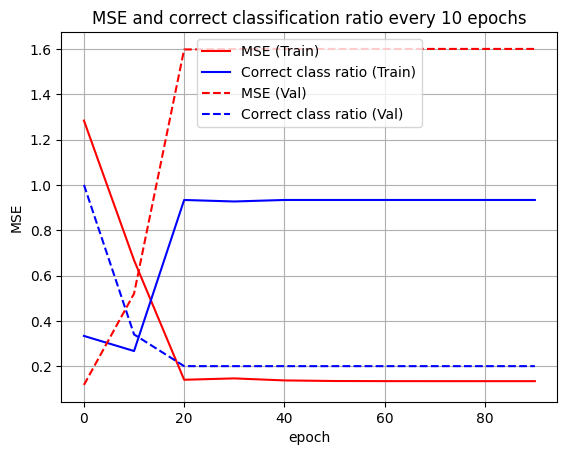

In [119]:
## Question 2 - Work with val data (special case; 20% of classA[0] < 0 and 80% of classA[0] > 0 for training, remaining for validation)
classA, classB, train_X, train_targets, val_X, val_targets = data_generator(mA=[2.0, 0.3], sampleA=1.0, sampleB=1.0, special_A_subsample=True)
for h in range(1, 15):
    generalised_delta_rule(train_X=train_X, train_targets=train_targets, val_X=val_X, val_targets=val_targets, epoch=100, eta=0.01, alpha=0.9, hidden_nodes=h)